In [3]:
# Importing Libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.signal import find_peaks
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from joblib import load, dump
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

**Read Data**

In [4]:
df = pd.read_csv('imu.csv')
df.head()

,ax,ay,az,gx,gy,gz,target,target_name
0,-0.28,7.54,1.52,6.34,20.30,0.49,0.0,Stomp
1,-0.23,7.16,1.94,8.48,6.04,0.24,0.0,Stomp
2,-0.16,7.09,1.85,11.65,-4.02,0.49,0.0,Stomp
3,-0.21,6.72,1.57,13.84,-9.57,-1.28,0.0,Stomp
4,-0.39,6.78,1.33,14.57,-3.05,-3.41,0.0,Stomp


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4231 entries, 0 to 4230
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ax           4231 non-null   float64
 1   ay           4231 non-null   float64
 2   az           4231 non-null   float64
 3   gx           4231 non-null   float64
 4   gy           4231 non-null   float64
 5   gz           4231 non-null   float64
 6   target       4231 non-null   float64
 7   target_name  4231 non-null   object 
dtypes: float64(7), object(1)
memory usage: 264.6+ KB


In [6]:
df.groupby('target_name').size()

target_name
FootTap       1069
FowardStep    1075
SideTap       1034
Stomp         1053
dtype: int64

In [19]:
ax_list, ay_list, az_list = [], [], []
gx_list, gy_list, gz_list = [], [], []
labels = []

window_size = 50
step_size = 10

# creating overlaping windows of size window-size
for i in range(0, df.shape[0] - window_size, step_size):
    ax = df['ax'].values[i: i + window_size]
    ay = df['ay'].values[i: i + window_size]
    az = df['az'].values[i: i + window_size]

    gx = df['gx'].values[i: i + window_size]
    gy = df['gy'].values[i: i + window_size]
    gz = df['gz'].values[i: i + window_size]

    l = stats.mode(df['target'][i: i + window_size])[0][0]

    ax_list.append(ax)
    ay_list.append(ay)
    az_list.append(az)

    gx_list.append(gx)
    gy_list.append(gy)
    gz_list.append(gz)
    labels.append(l)

# converting the signals from time domain to frequency domain using FFT
ax_list_fft = pd.Series(ax_list).apply(lambda x: np.abs(np.fft.fft(x))[1:step_size+1])
ay_list_fft = pd.Series(ay_list).apply(lambda x: np.abs(np.fft.fft(x))[1:step_size+1])
az_list_fft = pd.Series(az_list).apply(lambda x: np.abs(np.fft.fft(x))[1:step_size+1])

gx_list_fft = pd.Series(gx_list).apply(lambda x: np.abs(np.fft.fft(x))[1:step_size+1])
gy_list_fft = pd.Series(gy_list).apply(lambda x: np.abs(np.fft.fft(x))[1:step_size+1])
gz_list_fft = pd.Series(gz_list).apply(lambda x: np.abs(np.fft.fft(x))[1:step_size+1])

In [20]:
print(len(ax_list), len(ay_list), len(az_list))
print(len(gx_list), len(gy_list), len(gz_list))
print(len(ax_list_fft), len(ay_list_fft), len(az_list_fft))
print(len(gx_list_fft), len(gy_list_fft), len(gz_list_fft))
print(len(labels))

419 419 419
419 419 419
419 419 419
419 419 419
419


# **Statistical Measures**

In [21]:
lambda_functions = {
    'mean': lambda x: x.max(),
    'std': lambda x: x.std(),
    'aad': lambda x: np.mean(np.absolute(x - np.mean(x))),
    'min': lambda x: x.min(),
    'max': lambda x: x.max(),
    'meadian': lambda x: np.median(x),
    'mad': lambda x: np.median(np.absolute(x - np.median(x))),
    'iqr': lambda x: np.percentile(x, 75) - np.percentile(x, 25),
    'neg_count': lambda x: np.sum(x < 0),
    'pos_count': lambda x: np.sum(x > 0),
    'above_mean': lambda x: np.sum(x > x.mean()),
    'peak_count': lambda x: len(find_peaks(x)[0]),
    'skewness': lambda x: stats.skew(x),
    'kurtosis': lambda x: stats.kurtosis(x),
    'energy': lambda x: np.sum(x**2)/100,  
}

In [22]:
df_new = pd.DataFrame()

for key, value in lambda_functions.items():
    df_new[f'ax_{key}'] = pd.Series(ax_list).apply(value)
    df_new[f'ay_{key}'] = pd.Series(ay_list).apply(value)
    df_new[f'az_{key}'] = pd.Series(az_list).apply(value)

    df_new[f'gx_{key}'] = pd.Series(gx_list).apply(value)
    df_new[f'gy_{key}'] = pd.Series(gy_list).apply(value)
    df_new[f'gz_{key}'] = pd.Series(gz_list).apply(value)

    df_new[f'ax_{key}_fft'] = pd.Series(ax_list_fft).apply(value)
    df_new[f'ay_{key}_fft'] = pd.Series(ay_list_fft).apply(value)
    df_new[f'az_{key}_fft'] = pd.Series(az_list_fft).apply(value)

    df_new[f'gx_{key}_fft'] = pd.Series(gx_list_fft).apply(value)
    df_new[f'gy_{key}_fft'] = pd.Series(gy_list_fft).apply(value)
    df_new[f'gz_{key}_fft'] = pd.Series(gz_list_fft).apply(value)

df_new['ax_maxmin_diff'] = df_new['ax_max'] - df_new['ax_min']
df_new['ay_maxmin_diff'] = df_new['ay_max'] - df_new['ay_min']
df_new['az_maxmin_diff'] = df_new['az_max'] - df_new['az_min']

df_new['gx_maxmin_diff'] = df_new['gx_max'] - df_new['gx_min']
df_new['gy_maxmin_diff'] = df_new['gy_max'] - df_new['gy_min']
df_new['gz_maxmin_diff'] = df_new['gz_max'] - df_new['gz_min']

df_new['ax_maxmin_diff_fft'] = df_new['ax_max_fft'] - df_new['ax_min_fft']
df_new['ay_maxmin_diff_fft'] = df_new['ay_max_fft'] - df_new['ay_min_fft']
df_new['az_maxmin_diff_fft'] = df_new['az_max_fft'] - df_new['az_min_fft']

df_new['gx_maxmin_diff_fft'] = df_new['gx_max_fft'] - df_new['gx_min_fft']
df_new['gy_maxmin_diff_fft'] = df_new['gy_max_fft'] - df_new['gy_min_fft']
df_new['gz_maxmin_diff_fft'] = df_new['gz_max_fft'] - df_new['gz_min_fft']

# avg resultant
df_new['a_avg_result'] = [i.mean() for i in ((pd.Series(ax_list)**2 + pd.Series(ay_list)**2 + pd.Series(az_list)**2)**0.5)]
df_new['g_avg_result'] = [i.mean() for i in ((pd.Series(gx_list)**2 + pd.Series(gy_list)**2 + pd.Series(gz_list)**2)**0.5)]

df_new['a_avg_result_fft'] = [i.mean() for i in ((pd.Series(ax_list_fft)**2 + pd.Series(ay_list_fft)**2 + pd.Series(az_list_fft)**2)**0.5)]
df_new['g_avg_result_fft'] = [i.mean() for i in ((pd.Series(gx_list_fft)**2 + pd.Series(gy_list_fft)**2 + pd.Series(gz_list_fft)**2)**0.5)]


# signal magnitude area
df_new['a_sma'] = pd.Series(ax_list).apply(lambda x: np.sum(abs(x)/100)) \
                + pd.Series(ay_list).apply(lambda x: np.sum(abs(x)/100)) \
                + pd.Series(az_list).apply(lambda x: np.sum(abs(x)/100))
df_new['g_sma'] = pd.Series(gx_list).apply(lambda x: np.sum(abs(x)/100)) \
                + pd.Series(gy_list).apply(lambda x: np.sum(abs(x)/100)) \
                + pd.Series(gz_list).apply(lambda x: np.sum(abs(x)/100))

df_new['a_sma_fft'] = pd.Series(ax_list_fft).apply(lambda x: np.sum(abs(x)/100)) \
                + pd.Series(ay_list_fft).apply(lambda x: np.sum(abs(x)/100)) \
                + pd.Series(az_list_fft).apply(lambda x: np.sum(abs(x)/100))
df_new['g_sma_fft'] = pd.Series(gx_list_fft).apply(lambda x: np.sum(abs(x)/100)) \
                + pd.Series(gy_list_fft).apply(lambda x: np.sum(abs(x)/100)) \
                + pd.Series(gz_list_fft).apply(lambda x: np.sum(abs(x)/100))

df_new['target'] = pd.Series(labels)

In [23]:
df_new

,ax_mean,ay_mean,az_mean,gx_mean,gy_mean,gz_mean,ax_mean_fft,ay_mean_fft,az_mean_fft,gx_mean_fft,...,gz_maxmin_diff_fft,a_avg_result,g_avg_result,a_avg_result_fft,g_avg_result_fft,a_sma,g_sma,a_sma_fft,g_sma_fft,target
0,0.88,19.60,2.70,14.57,20.30,24.09,7.839528,25.657012,4.425305,72.067531,...,35.150554,9.511969,8.400143,17.310625,80.909130,5.9082,5.8937,2.288630,12.935718,0.0
1,0.88,13.61,2.66,13.05,19.57,18.17,4.748161,9.607781,4.711685,48.750936,...,73.671317,9.841149,6.919655,8.163159,82.354068,6.0562,4.9335,1.196903,13.193718,0.0
2,-0.58,11.29,2.14,13.05,6.95,18.17,3.751254,7.728784,3.196807,69.727246,...,67.120221,9.802038,6.442119,5.212210,90.566278,5.9669,4.8880,0.811371,14.129554,0.0
3,0.64,11.29,2.14,13.05,6.95,18.17,5.672983,27.020890,6.105394,69.033141,...,77.289394,9.358718,6.781931,12.073206,92.984670,5.6755,5.1282,1.660166,14.427981,0.0
4,7.36,19.60,3.05,143.72,60.55,53.41,19.240070,47.162632,11.165923,184.122695,...,140.605066,9.598466,17.263516,24.526794,215.766382,5.9799,13.1994,3.661745,34.128442,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,1.41,10.83,3.22,41.16,42.38,30.61,30.466868,11.048193,36.765929,821.819366,...,388.544229,9.648680,38.922261,16.330861,327.861622,6.0673,31.2074,2.649561,54.205070,3.0
415,1.41,10.83,3.22,41.16,42.38,30.61,35.416605,10.536740,42.781553,840.122508,...,454.847910,9.727795,38.117834,15.882007,291.597045,5.9942,30.7458,2.572782,48.741558,3.0
416,1.41,10.83,3.22,41.16,42.38,27.19,33.305169,9.134003,40.505080,710.969155,...,389.682749,9.709609,32.233808,14.055688,254.467247,5.8899,26.1280,2.271427,42.305011,3.0
417,0.91,10.83,2.77,41.16,42.38,25.85,23.250958,7.896596,27.979221,646.767275,...,317.708538,9.641013,26.107843,12.781382,246.968990,5.7396,21.0663,2.085207,41.080563,3.0


**Train-Test Split**

In [24]:
X = df_new.drop(columns=['target']).values
Y = df_new['target'].values

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.15, random_state=42)  # Train-Test Split

print((X_train.shape, y_train.shape))
print((X_test.shape, y_test.shape))

((356, 200), (356,))
((63, 200), (63,))


**Feature Scaling**

In [30]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

dump(scaler, './weights/scaler.joblib')

['./weights/scaler.joblib']

**Utility Functions for Evaluating Models**

In [31]:
def compute_roc(y_test, y_score):
    y_test_binarize = label_binarize(y_test, classes=[0, 1, 2, 3])
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarize.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    return fpr, tpr, roc_auc


def evaluate(X_test, y_true, model):                            # Function for priniting the classification report
    y_pred = model.predict(X_test)
    cr = classification_report(y_true, y_pred, zero_division=0)

    print("\nClassification Report:\n", cr)
    
    cm = confusion_matrix(y_true,y_pred,labels=[0, 1, 2, 3])
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Stomp','FootTap','FowardStep','SideTap'])

    y_score = model.predict_proba(X_test)
    fpr, tpr, roc_auc = compute_roc(y_test, y_score)

    # Plot Confusion Matrix
    fig = plt.figure(figsize=(12,4))
    ax1 = fig.add_subplot(121)
    cm_display.plot(ax=ax1, cmap="Blues", colorbar=False)
    ax1.set_title("Confusion Matrix")

    # Plot ROC curve
    ax2 = fig.add_subplot(122)
    ax2.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]))
    
    target_names = ['Stomp','FootTap','FowardStep','SideTap']
    for i in range(4):
        ax2.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                    ''.format(target_names[i], roc_auc[i]))
        
    ax2.plot([0, 1], [0, 1],'k--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve')
    ax2.legend(loc='best') 
    plt.show()

**Setting Hyperparameters of Models**

In [32]:
log_parameters = {
    'penalty': ['l1','l2'],
    'C': [0.01, 1, 10 ,50],
    'solver': ['liblinear','newton-cg', 'sag', 'saga', 'lbfgs']
}

rf_parameters = {
    'n_estimators': [10,50,100],
    'criterion': ['gini', 'entropy'],
    'max_depth': np.linspace(10,30,5).astype(int)
}

dt_parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.linspace(10,30,5).astype(int)
}

svm_parameters = {
    'C': [0.01, 1, 10 ,50],
    'kernel': ['linear'],
    'decision_function_shape': ['ovo', 'ovr']
}

xgb_parameters = {
    'learning_rate': [0.1,1],
    'n_estimators': [10,50],
    'max_depth': np.linspace(10,30,5).astype(int)
}

log_reg = LogisticRegression(n_jobs=-1)
rf = RandomForestClassifier(n_jobs=-1)
dt = DecisionTreeClassifier()
svm = SVC(probability=True)
xgb = GradientBoostingClassifier()

cv_dict = {0: 'Logistic Regression', 1: 'Random Forest', 2:'Decision Tree', 3:'Support Vector Machine', 4:'XgBoost'}
cv_models = [log_reg, rf, dt, svm, xgb]
parameters = [log_parameters, rf_parameters, dt_parameters, svm_parameters, xgb_parameters]

**Training and Evaluating Models**

Tuning Hyperparameters of Logistic Regression:
Tuned Hyperparameters : {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy : 0.9943977591036415

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        22
         1.0       1.00      1.00      1.00        13
         2.0       1.00      1.00      1.00        15
         3.0       1.00      1.00      1.00        13

    accuracy                           1.00        63
   macro avg       1.00      1.00      1.00        63
weighted avg       1.00      1.00      1.00        63



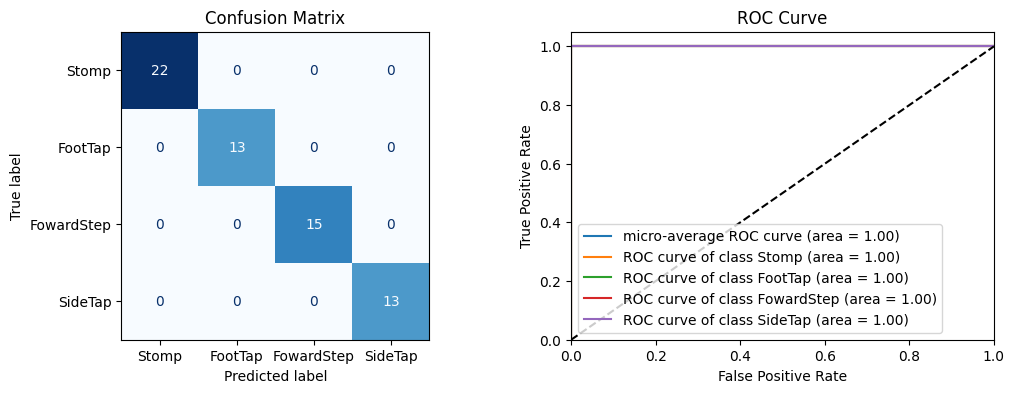

--------------------------------------------------------------------------------

Tuning Hyperparameters of Random Forest:
Tuned Hyperparameters : {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 50}
Accuracy : 0.9887717798984

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        22
         1.0       1.00      1.00      1.00        13
         2.0       1.00      1.00      1.00        15
         3.0       1.00      1.00      1.00        13

    accuracy                           1.00        63
   macro avg       1.00      1.00      1.00        63
weighted avg       1.00      1.00      1.00        63



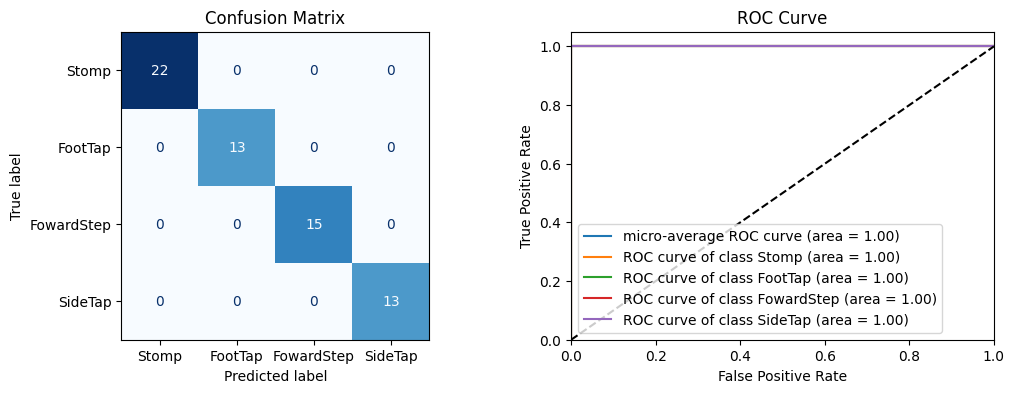

--------------------------------------------------------------------------------

Tuning Hyperparameters of Decision Tree:
Tuned Hyperparameters : {'criterion': 'gini', 'max_depth': 20}
Accuracy : 0.9831458006931587

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.95      0.98        22
         1.0       0.93      1.00      0.96        13
         2.0       1.00      1.00      1.00        15
         3.0       1.00      1.00      1.00        13

    accuracy                           0.98        63
   macro avg       0.98      0.99      0.98        63
weighted avg       0.99      0.98      0.98        63



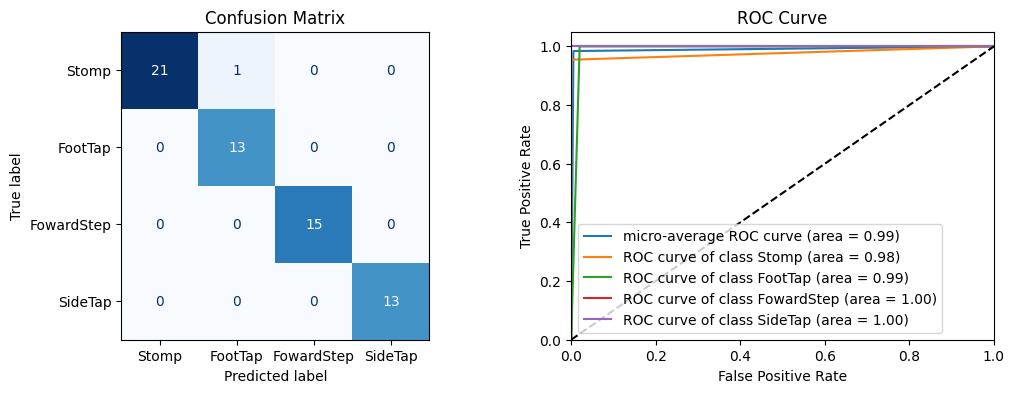

--------------------------------------------------------------------------------

Tuning Hyperparameters of Support Vector Machine:
Tuned Hyperparameters : {'C': 1, 'decision_function_shape': 'ovo', 'kernel': 'linear'}
Accuracy : 0.9887717798984

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        22
         1.0       1.00      1.00      1.00        13
         2.0       1.00      1.00      1.00        15
         3.0       1.00      1.00      1.00        13

    accuracy                           1.00        63
   macro avg       1.00      1.00      1.00        63
weighted avg       1.00      1.00      1.00        63



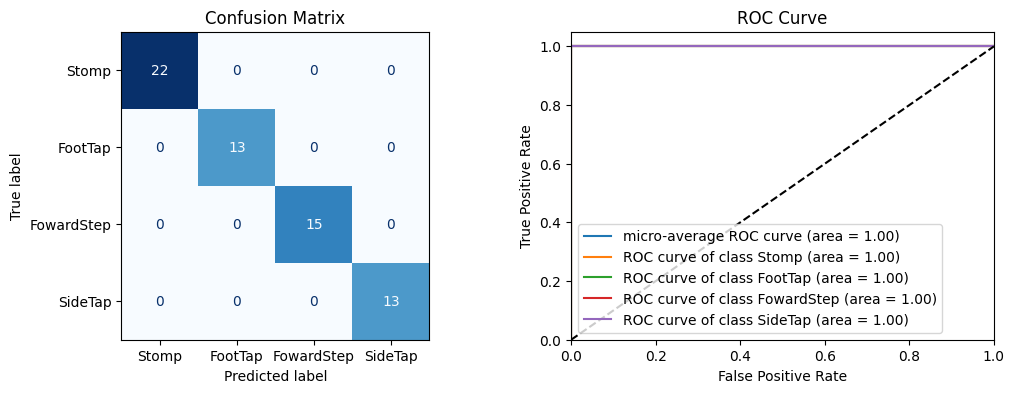

--------------------------------------------------------------------------------

Tuning Hyperparameters of XgBoost:
Tuned Hyperparameters : {'learning_rate': 1, 'max_depth': 10, 'n_estimators': 10}
Accuracy : 0.9887480415895172

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.91      0.95        22
         1.0       0.93      1.00      0.96        13
         2.0       0.94      1.00      0.97        15
         3.0       1.00      1.00      1.00        13

    accuracy                           0.97        63
   macro avg       0.97      0.98      0.97        63
weighted avg       0.97      0.97      0.97        63



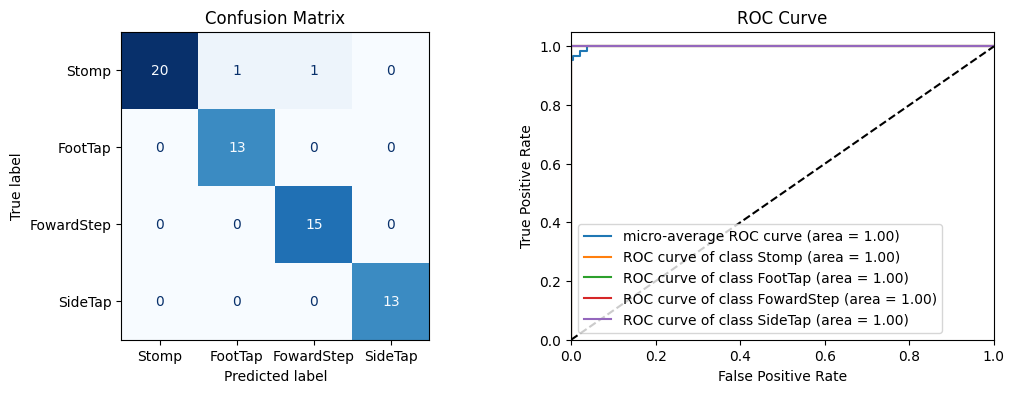

--------------------------------------------------------------------------------



In [33]:
estimators = []
for i, classifier in enumerate(cv_models):
    print(f'Tuning Hyperparameters of {cv_dict[i]}:')
    # create a Pipeline object
    clf = GridSearchCV(classifier,              # model
              param_grid = parameters[i],       # hyperparameters
              scoring='accuracy',                     # metric for scoring
              cv=3)                             # number of folds
    
    clf.fit(X_train,y_train)
    print("Tuned Hyperparameters :", clf.best_params_)
    print("Accuracy :", clf.best_score_)
    evaluate(X_test, y_test, clf)
    # add the clf to the estimators list
    estimators.append((classifier.__class__.__name__, clf))
    dump(clf, f'./weights/{classifier.__class__.__name__}.joblib')
    print('--------------------------------------------------------------------------------\n')

**Ensembling Models**

In [ ]:
def getClassifier(base_estimators,final_estimator):
    '''
    Initializing the esemble stacking classifier
    '''
    model = StackingClassifier(estimators=base_estimators,
                            final_estimator=final_estimator,
                            cv=3) 
    return model


Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.91      0.95        22
         1.0       0.93      1.00      0.96        13
         2.0       0.94      1.00      0.97        15
         3.0       1.00      1.00      1.00        13

    accuracy                           0.97        63
   macro avg       0.97      0.98      0.97        63
weighted avg       0.97      0.97      0.97        63



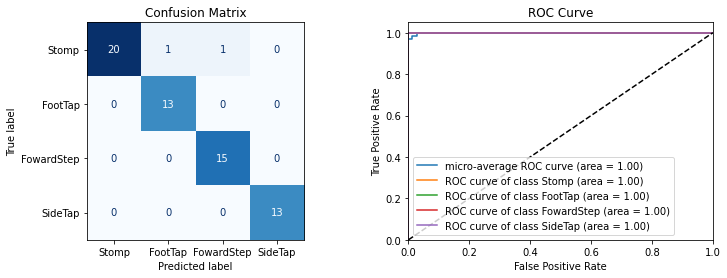

In [ ]:
ensembled = getClassifier(estimators[1:],estimators[0][1])
ensembled.fit(X_train,y_train)
evaluate(X_test, y_test, ensembled)